<a href="https://colab.research.google.com/github/ntminh981/ApplyParallelProgramming_Group5/blob/pcminh/poissionmatting_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Clone git project

In [ ]:
import os
if not os.path.exists('/content/git'):
  !git clone https://github.com/ntminh981/ApplyParallelProgramming_Group5.git git

Cloning into 'git'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 46 (delta 7), reused 21 (delta 2), pack-reused 0
Receiving objects: 100% (46/46), 3.83 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
from numba import cuda

# # Get the current CUDA device
# device = cuda.get_current_device()

# # Get the maximum threads per block for the current device
# max_threads_per_block = device.MAX_THREADS_PER_BLOCK

# print(f"Maximum threads per block: {max_threads_per_block}")

# 2. Khai báo thư viện

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
import time
import scipy
from scipy.optimize import fmin
from numba import cuda

# 3. Load & show input

In [ ]:
IMAGES_FOLDER_PATH  = "/content/git/img"
img_name            = 'img3.png'
trimap_name         = 'tri3.png'
new_bg_name         = 'new_bg1.jpg'

In [ ]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [ ]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, trimap_name),0)

new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, new_bg_name))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0]))

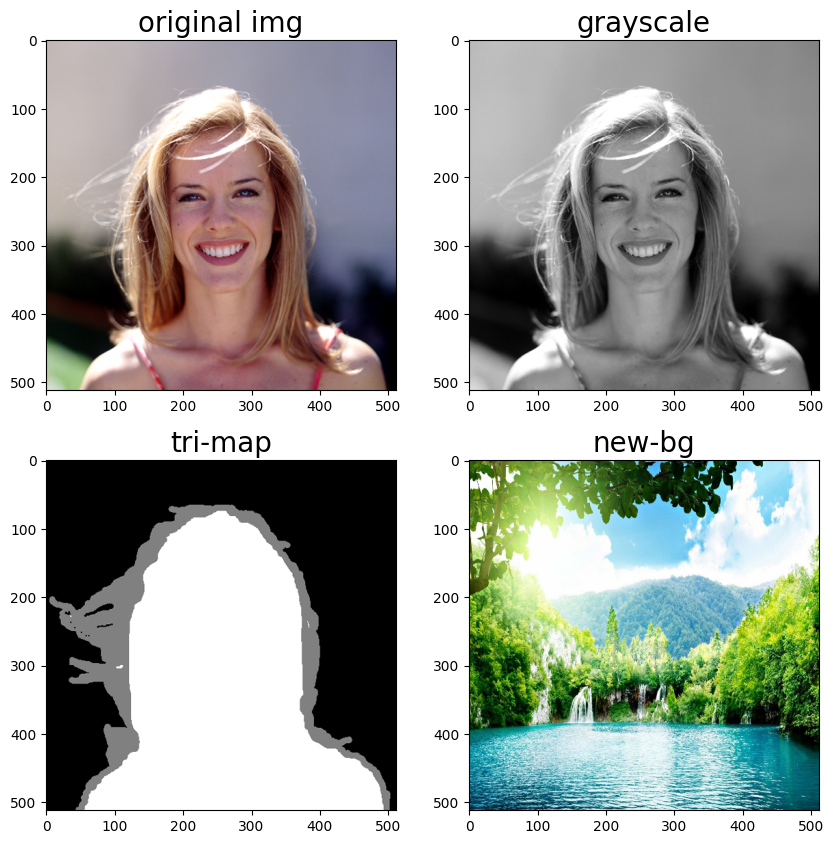

In [ ]:
display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# 4. Global Matting

+ 1 image có thể được biểu diễn như sau:

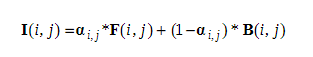

+ Đạo hàm 2 vế:

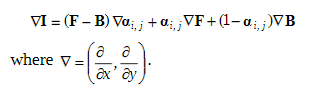

+ Giả sử foreground và background smooth, tức là $\Delta F$ và $\Delta B$ tiệm cận 0:
$$\nabla I=(F-B)\nabla \alpha ⟹ \nabla \alpha =\frac{\nabla I}{F-B}$$

+ Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor

+ Giải Poisson Equation bằng Phép lặp Gauss Siedel với phương pháp overrealaxation.

 Với,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)} + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$

$\beta$ nằm trong khoảng [1,2] (chọn $\beta$=1)



In [ ]:
import math

In [ ]:
@cuda.jit
def mulMatByRow(A, B, C):
    c, r = cuda.grid(2)

    if r < C.shape[0] and c < C.shape[1]:
        C[r, c] = A[r, c] * B[r, c]

def mulMatrix(A, B):
    C = np.empty((A.shape[0], B.shape[1]), dtype=int)
    block_size = (32, 32)
    grid_size = (math.ceil(C.shape[1] / block_size[0]),
                 math.ceil(C.shape[0] / block_size[1]))
    mulMatByRow[grid_size, block_size](A, B, C)

    return C

In [ ]:
@cuda.jit
def sumMat(A, B, C):
  c,r = cuda.grid(2)
  if r < C.shape[0] and c < C.shape[1]:
    C[r,c] = A[r,c] + B[r,c]

def sumMatrix(A, B):
  C = np.empty((A.shape[0], B.shape[1]), dtype=int)
  block_size = (32,32)
  grid_size = (math.ceil(C.shape[1] / block_size[0]),
             math.ceil(C.shape[0] / block_size[1]))
  sumMat[grid_size, block_size](A,B,C)
  return C

In [ ]:
def calc_masks_parallel(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    # fg = img_gray*(mask_fg)
    # bg = img_gray*(mask_bg)
    # unknown = img_gray*mask_unknown

    start = time.time()
    fg = mulMatrix(img_gray, mask_fg);
    end = time.time()
    print(f'Time fg: {end-start}\n')

    start = time.time()
    bg = mulMatrix(img_gray, mask_bg);
    end = time.time()
    print(f'Time bg: {end-start}\n')

    start = time.time()
    unknown = mulMatrix(img_gray, mask_unknown);
    end = time.time()
    print(f'Time unknown: {end-start}\n')

    np.savetxt('omat_p.gz', fg, fmt='%i')

    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

In [ ]:
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))


    start = time.time()
    fg = img_gray*(mask_fg)
    end = time.time()
    print(f'Time fg: {end-start}\n')

    start = time.time()
    bg = img_gray*(mask_bg)
    end = time.time()
    print(f'Time bg: {end-start}\n')

    start = time.time()
    unknown = img_gray*mask_unknown
    end = time.time()
    print(f'Time unknown: {end-start}\n')

    np.savetxt('omat_s.gz', fg, fmt='%i')

    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

In [ ]:
calc_masks(tri, img_gray)
print("--------------\n")
print("Parallel")
imgs, title = calc_masks_parallel(tri, img_gray)

f_s = np.loadtxt('omat_s.gz', dtype=int)
f_p = np.loadtxt('omat_p.gz', dtype=int)
np.mean(np.abs(f_p - f_s))

Time fg: 9.465217590332031e-05

Time bg: 0.00010323524475097656

Time unknown: 0.00010514259338378906

--------------

Parallel


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time fg: 0.11777615547180176

Time bg: 0.003915309906005859

Time unknown: 0.0035109519958496094



0.0

In [ ]:
mask_fg, fg, mask_bg, bg, mask_unknown, unknown = imgs

In [ ]:
def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    start = time.time()
    F = img_gray*(mask_fg+mask_unknown)
    end = time.time()
    print(f'F: {end-start}\n')

    start = time.time()
    B = img_gray*(mask_bg+mask_unknown)
    end = time.time()
    print(f'B: {end-start}\n')

    return F, B

In [ ]:
def fb_parallel(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    start = time.time()
    F = mulMatrix(img_gray, sumMatrix(mask_fg, mask_unknown))
    end = time.time()
    print(f'F: {end-start}\n')

    start = time.time()
    B = mulMatrix(img_gray, sumMatrix(mask_bg, mask_unknown))
    end = time.time()
    print(f'B: {end-start}\n')

    return F, B

In [ ]:
fb(img_gray,mask_fg,mask_bg,mask_unknown)

print("---------------\n")
print("Parallel")

fb_parallel(img_gray,mask_fg,mask_bg,mask_unknown)

F: 0.00014925003051757812

B: 0.00010919570922851562

---------------

Parallel


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


F: 0.4737062454223633

B: 0.01903820037841797



/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[  1,   1,   1, ...,   1,   1,   1],
        [  1,   1,   1, ...,   1,   1,   1],
        [  1,   1,   1, ...,   9,   9,   1],
        ...,
        [  1,   1,   1, ..., 100,  93,   1],
        [  1,   1,   1, ...,  89,  96,   1],
        [  1,   1,   1, ...,   1,   1,   1]]))

In [ ]:
def globalAlphaMatting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation

    :returns :A numpy array representing Matte produced and time taken to calculate it
    """
    prev_alpha = np.zeros(alpha.shape)

    tic = time.time()
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])

        prev_alpha = alpha.copy()
    tac = time.time()
    return alpha, tac-tic

@cuda.jit
def globalAlphaMattingParallelRow(row, alpha,prev_alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    col = tx + ty * bw

    if col < alpha.shape[1]:  # Check array boundaries
      if unknown_seg[row,col]!=0 :
          alpha[row,col] = beta*(alpha[row-1,col]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4

@cuda.jit
def globalAlphaMattingParallelCol(col, alpha,prev_alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    row = tx + ty * bw

    if row < alpha.shape[0]:  # Check array boundaries
      if unknown_seg[row,col]!=0 :
          alpha[row,col] += beta*(alpha[row,col-1])/4 + (1-beta)*prev_alpha[row,col]

          for i in range(0, row):
            alpha[row,col] += beta*(alpha[i,col-1])/4 + (1-beta)*prev_alpha[i,col]

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground
    :param B: A numpy array representing Approximate Background
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region

    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :returns estimated alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg, fg, mask_bg, bg, mask_unknown, unknown = imgs

    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

def matting_combined(tri, img_gray, useCuda=False):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    if useCuda:
      # Get the current CUDA device
      device = cuda.get_current_device()

      # Get the maximum threads per block for the current device
      max_threads_per_block = device.MAX_THREADS_PER_BLOCK

      block_size = max_threads_per_block
      grid_size = int(np.ceil(img_gray.shape[0]/block_size))

      alpha = estimate_alpha.copy()
      prev_alpha = np.zeros(alpha.shape)

      threshold = 0.1

      tic = time.time()
      for _ in range(50):
          diff = np.sum(np.abs(prev_alpha-alpha))
          if diff < threshold:
              break
          for i in range(1,alpha.shape[0]-1):
            globalAlphaMattingParallelRow[block_size, grid_size](i, alpha, prev_alpha, d2alpha, mask_unknown, 50, 0.1, 1)
          # display_img_arr(alpha, 1,2,(10,10),['test'])
          for j in range(1,alpha.shape[1]-1):
            globalAlphaMattingParallelCol[block_size, grid_size](j, alpha, prev_alpha, d2alpha, mask_unknown, 50, 0.1, 1)

          prev_alpha = alpha.copy()
      tac = time.time()
      deltaTime = tac-tic
    else:
      alpha, deltaTime = globalAlphaMatting(estimate_alpha,d2alpha,mask_unknown)
      alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown, 'time':deltaTime}


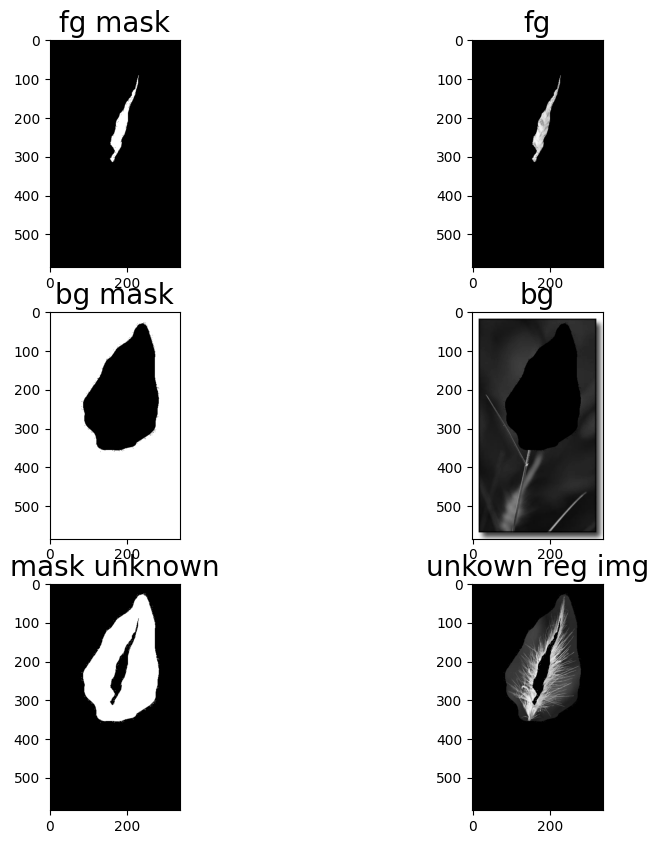

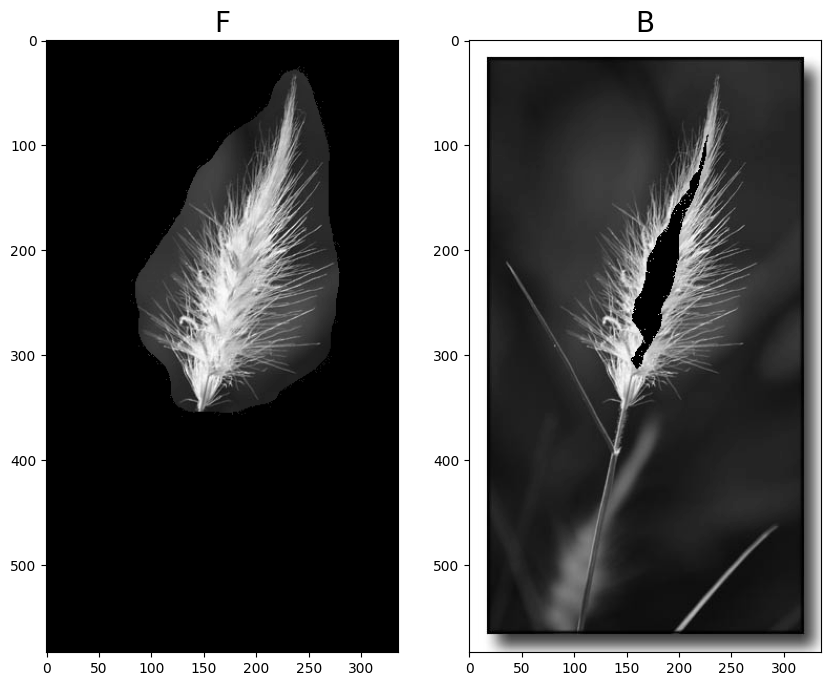

<ipython-input-31-9513dbc6ab08>:108: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


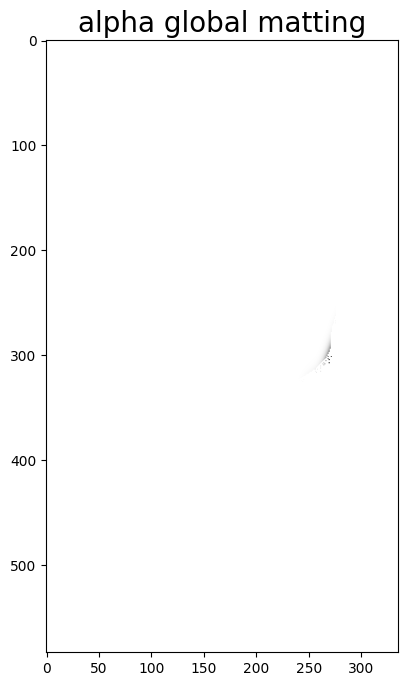

In [ ]:
all_data = matting_combined(tri, img_gray, True)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()
## NOW all_data VARIABLE CONTAINS img, img_GRAY, ALPHA, DIFF, F, B, UNKNOWN


# display_img_arr([new_img ], 1,1,(10,10),['img with new bg'])

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Sequential version: ', all_data['time'])

Sequential version:  4.662696599960327


# Alpha blending

### I = α F + (1 − α )B

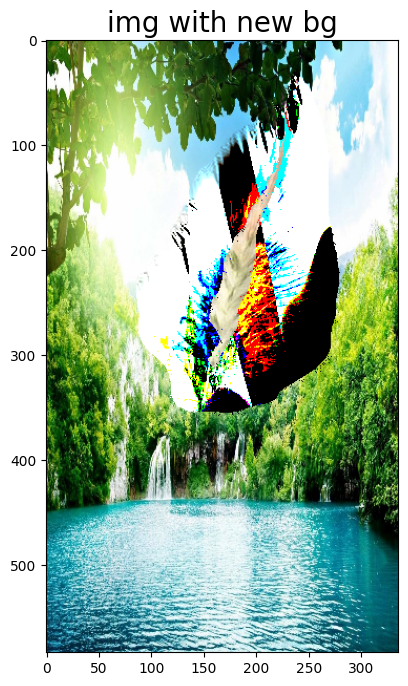

In [ ]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

In [ ]:
#alpha blending
alpha = all_data['alpha']
new_img_global = alpha_blend(new_bg,alpha,img )
# display_img_arr([new_img_global], 1,2,(10,10),['new image'])